# Step #1 Make Imports and Check Training Device

In [1]:
# A tutorial for this file is available at www.relataly.com

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

tf.config.allow_growth = True
tf.config.per_process_gpu_memory_fraction = 0.9

from random import randint
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random as rdn

# check the tensorflow version
print('Tensorflow Version: ' + tf.__version__)

# check the number of available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.9.1
Num GPUs: 0


# Step #2 Define the Prediction Classes

<AxesSubplot: xlabel='count', ylabel='category'>

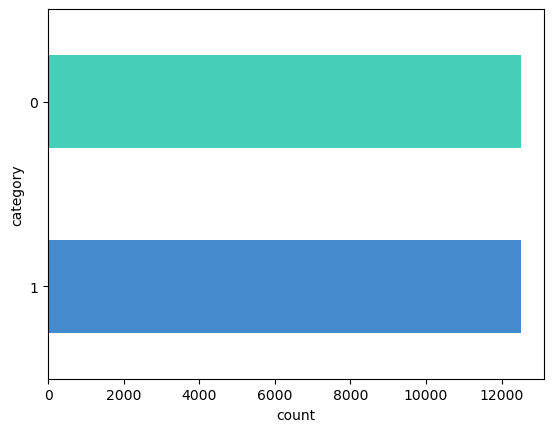

In [4]:
# set the directory for train and validation images
train_path = 'data/images/cats-and-dogs/train/'
#test_path = 'data/cats-and-dogs/test/'

# function to create a list of image labels 
def createImageDf(path):
    filenames = os.listdir(path)
    categories = []

    for fname in filenames:
        category = fname.split('.')[0]
        if category == 'dog':
            categories.append(1)
        else:
            categories.append(0)
    df = pd.DataFrame({
        'filename':filenames,
        'category':categories
    })
    return df

# display the header of the train_df dataset
image_df = createImageDf(train_path)
image_df.head(5)

sns.countplot(y='category', data=image_df, palette=['#2FE5C7',"#2F8AE5"], orient="h", width=0.5)

# Step #3 Plot Sample Images

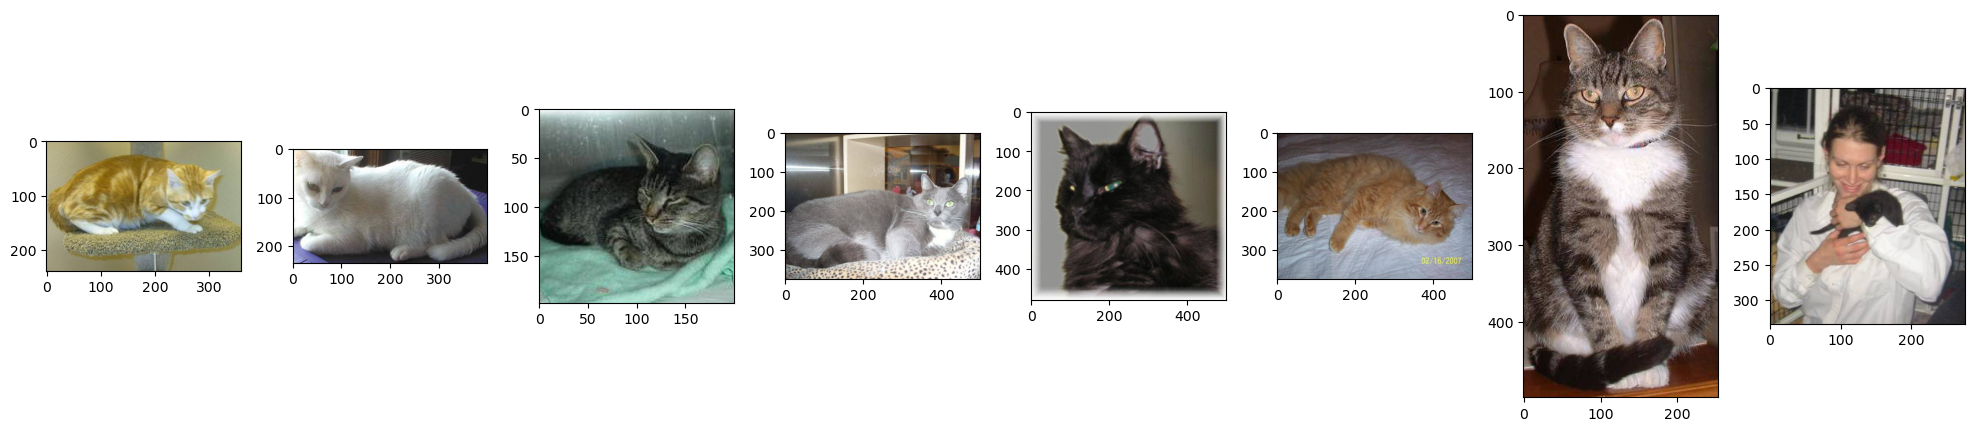

In [5]:
n_pictures = 8 # number of pictures to be shown
nrows = 1
ncols = int(round(n_pictures / nrows, 0))
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 30))
for i, ax in enumerate(fig.axes):
    if i < n_pictures:
        random_pic_name = str(rdn.randint(1, 1000)) + '.jpg'
        image_name = 'cat.' + random_pic_name if i < ncols else 'dog.' + random_pic_name
        plt.tight_layout()
        #axs.set_xlabel(image_name)    
        #ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(Image.open(train_path + image_name))

# Step #4 Split the Data

In [4]:
image_df["category"] = image_df["category"].replace({0:'cat',1:'dog'})

train_df, validate_df = train_test_split(image_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
total_train = train_df.shape[0]

validate_df = validate_df.reset_index(drop=True)
total_validate = validate_df.shape[0]
print(f"train data size: {total_train}")
print(train_df.head())
print(f"validate data size: {total_validate}")
print(validate_df.head())

train data size: 20000
        filename category
0   dog.8479.jpg      dog
1    dog.876.jpg      dog
2  cat.10915.jpg      cat
3  dog.10127.jpg      dog
4  cat.11377.jpg      cat
validate data size: 5000
        filename category
0    cat.493.jpg      cat
1   dog.9112.jpg      dog
2    cat.745.jpg      cat
3  dog.11022.jpg      dog
4  dog.11363.jpg      dog


# Step #5 Preprocess the Images

In [5]:
# set the dimensions to which we will convert the images
img_width, img_height = 100, 100
target_size = (img_width, img_height)
batch_size = 32
rescale=1.0/255

def createGenerator(df, image_path, target_size, batch_size, rescale):    
    datagen = ImageDataGenerator(rescale=rescale)
    return datagen.flow_from_dataframe(
        df, 
        image_path,
        x_col='filename', y_col='category',
        classes=['dog', 'cat'],
        target_size=target_size,
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='binary')

# configure the train and test data generators
print('Train data:')
train_generator = createGenerator(train_df, train_path, target_size, batch_size, rescale)
    
print('Test data:')
validation_generator = createGenerator(validate_df, train_path, target_size, batch_size, rescale)

Train data:
Found 20000 validated image filenames belonging to 2 classes.
Test data:
Found 5000 validated image filenames belonging to 2 classes.


# Step #6 Define and Compile the Convolutional Neural Network

In [6]:
# define the input format of the model
input_shape = (img_width, img_height, 3)
print("input_shape: " + str(input_shape))

# define  model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(128, (3, 3),  strides=(1, 1),activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model and print its architecture
opt = SGD(learning_rate=0.001, momentum=0.9)
history = model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

input_shape: (100, 100, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            

# Step #7 Train the Convolutional Neural Network

In [7]:
# train the model
epochs = 35
early_stop = EarlyStopping(monitor='loss', patience=6, verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stop],
    steps_per_epoch=len(train_generator),
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/35
625/625 [==============================] - 121s 194ms/step - loss: 0.7050 - accuracy: 0.5282 - val_loss: 0.6902 - val_accuracy: 0.5824
Epoch 2/35
625/625 [==============================] - 115s 183ms/step - loss: 0.6853 - accuracy: 0.5469 - val_loss: 0.6856 - val_accuracy: 0.5806
Epoch 3/35
625/625 [==============================] - 115s 184ms/step - loss: 0.6744 - accuracy: 0.5752 - val_loss: 0.6746 - val_accuracy: 0.5806
Epoch 4/35
625/625 [==============================] - 112s 180ms/step - loss: 0.6569 - accuracy: 0.5987 - val_loss: 0.6593 - val_accuracy: 0.6110
Epoch 5/35
625/625 [==============================] - 115s 185ms/step - loss: 0.6423 - accuracy: 0.6194 - val_loss: 0.6474 - val_accuracy: 0.6134
Epoch 6/35
625/625 [==============================] - 116s 185ms/step - loss: 0.6309 - accuracy: 0.6370 - val_loss: 0.6386 - val_accuracy: 0.6260
Epoch 7/35
625/625 [==============================] - 115s 183ms/step - loss: 0.6139 - accuracy: 0.6539 - val_loss: 0.6082 -

In [ ]:
# Safe the weights
model.save_weights('cats-and-dogs-weights-v1.h5')

# Define model as during training
# model architecture

# Loads the weights
# model.load_weights('cats-and-dogs-weights-v1.h5')

# Step #8 Visualize Model Performance

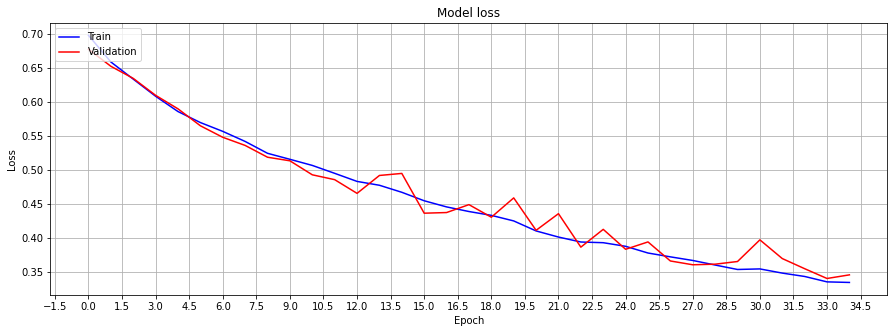

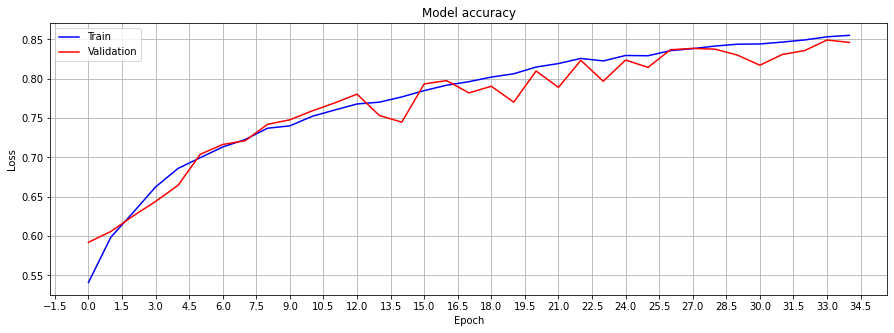

In [ ]:
def plot_loss(history, value1, value2, title):
    fig, ax = plt.subplots(figsize=(15, 5), sharex=True)
    plt.plot(history.history[value1], 'b')
    plt.plot(history.history[value2], 'r')
    plt.title(title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.grid()
    plt.show()

# plot training & validation loss values
plot_loss(history, "loss", "val_loss", "Model loss")
plot_loss(history, "accuracy", "val_accuracy", "Model accuracy")


Accuracy: 0.85


Text(0.5, 51.0, 'Predicted label')

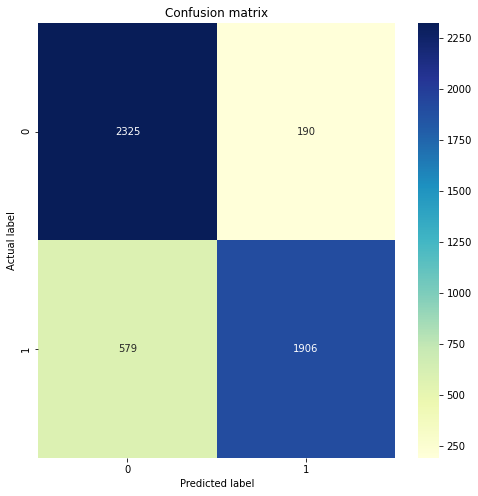

In [ ]:
# function that returns the label for a given probability
def getLabel(prob):
    if(prob > .5):
               return 'dog'
    else:
               return 'cat'

# get the predictions for the validation data
val_df = validate_df.copy()
val_df['pred'] = ""
val_pred_prob = model.predict(validation_generator)

for i in range(val_pred_prob.shape[0]):
    val_df['pred'][i] = getLabel(val_pred_prob[i])
          
# create a confusion matrix
y_val = val_df['category']
y_pred = val_df['pred']

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))
cnf_matrix = confusion_matrix(y_val, y_pred)

# plot the confusion matrix in form of a heatmap

%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(8, 8))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Step #9 Make Predictions on Sample Images

Found 46 validated image filenames belonging to 2 classes.
Accuracy: 0.76


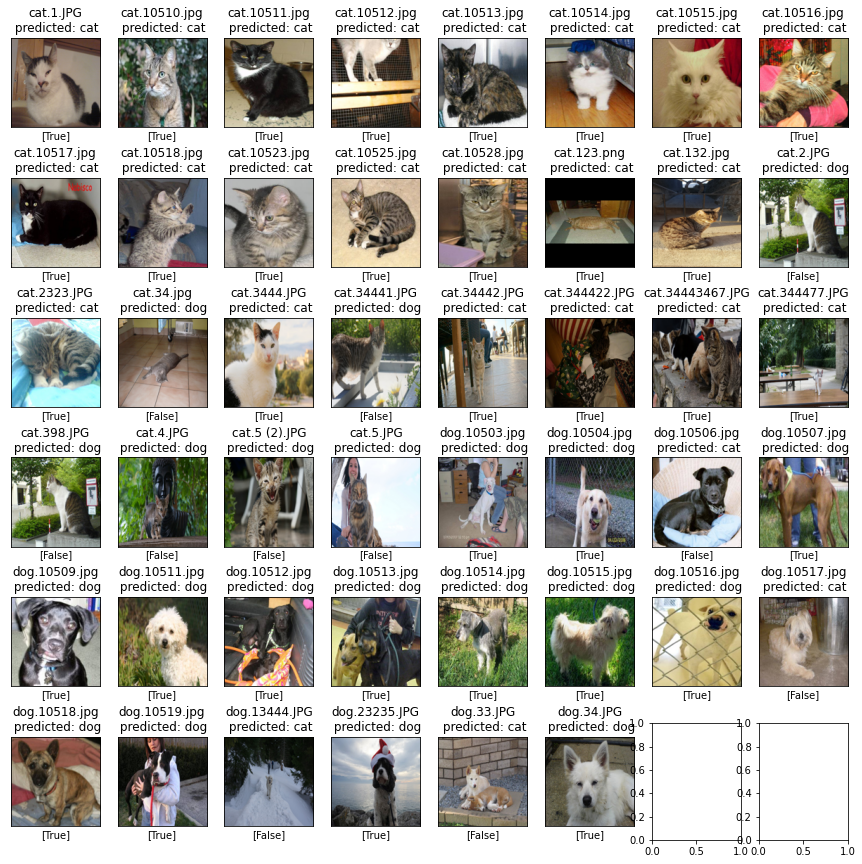

In [ ]:
# set the path to the sample images
sample_path = "data/images/cats-and-dogs/sample/"
sample_df = createImageDf(sample_path)
sample_df['category'] = sample_df['category'].replace({0:'cat',1:'dog'})
sample_df['pred'] = ""

# create an image data generator for the sample images - we will only rescale the images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    sample_df, 
    sample_path,    
    shuffle=False,
    x_col='filename', y_col='category',
    target_size=target_size)

# make the predictions 
pred_prob = model.predict(test_generator)
image_number = pred_prob.shape[0]

# define the plot size
for i in range(pred_prob.shape[0]):
    sample_df['pred'][i] = getLabel(pred_prob[i])
    
print('Accuracy: {:.2f}'.format(accuracy_score(sample_df['category'], sample_df['pred'])))

nrows = 6
ncols = int(round(image_number / nrows, 0))
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
    if i < sample_df.shape[0]:
        filepath = sample_path + sample_df.at[i ,'filename']
        img = Image.open(filepath).resize(target_size)
        ax.imshow(img)
        ax.set_title(sample_df.at[i ,'filename'] + '\n' + ' predicted: '  + str(sample_df.at[i ,'pred']))
        result = [True if sample_df.at[i ,'pred'] == sample_df.at[i ,'category'] else False]
        ax.set_xlabel(str(result))
        ax.set_xticks([]); ax.set_yticks([])